In [1]:
!pip install git+https://github.com/brianbt/btorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/brianbt/btorch to /tmp/pip-req-build-6v_kcqdv
  Running command git clone -q https://github.com/brianbt/btorch /tmp/pip-req-build-6v_kcqdv


In [2]:
import torch
import btorch
from btorch import nn
import btorch.nn.functional as F
from btorch.vision.utils import UnNormalize
from torchvision import transforms, datasets
from tqdm import tqdm
from matplotlib import pyplot as plt

# Load Dataset, CIFAR10

In [3]:
# Load CIFAR10 dataset, do augmentation on the trainset
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(0.5),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])
transform_test = transforms.Compose([
  transforms.ToTensor()
  ])
trainset = datasets.CIFAR10('./cifar10',train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10('./cifar10',train=False, download=True, transform=transform_test)

# Only select the `dog` class
train_idx = torch.tensor(trainset.targets,dtype=torch.long) == 6
test_idx = torch.tensor(testset.targets,dtype=torch.long) == 6
trainset.targets = torch.tensor(trainset.targets,dtype=torch.long)[train_idx]
trainset.data = trainset.data[train_idx]
testset.targets = torch.tensor(testset.targets,dtype=torch.long)[test_idx]
testset.data = testset.data[test_idx]

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Add to dataloader
batch_size = 16
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=2, pin_memory=True, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=2, pin_memory=True, drop_last=True)

# Create VAE Model

## Encoder and Decoder Module

In [5]:
class Encoder(nn.Module):
  def __init__(self, hidden_dim):
    super(Encoder, self).__init__()
    self.layer1 = nn.Conv2d(3, 16, (3,3), 2)
    self.bn1 = nn.BatchNorm2d(16)
    self.layer2 = nn.Conv2d(16, 32, (3,3), 2)
    self.bn2 = nn.BatchNorm2d(32)
    self.mu = nn.Linear(1568, hidden_dim)
    self.logsigma = nn.Linear(1568, hidden_dim)

  def forward(self,x):
    x = torch.relu(self.bn1(self.layer1(x)))
    x = torch.relu(self.bn2(self.layer2(x)))
    x = torch.flatten(x, 1)
    mu = self.mu(x)
    logsigma = self.logsigma(x)
    return mu, logsigma

In [6]:
class Decoder(nn.Module):
  def __init__(self, hidden_dim):
    super(Decoder, self).__init__()
    self.input = nn.Linear(hidden_dim, 1568)
    self.layer1 = nn.ConvTranspose2d(32, 16, (3,3), 2)
    self.bn1 = nn.BatchNorm2d(16)
    self.layer2 = nn.ConvTranspose2d(16, 16, (4,4), 2)
    self.bn2 = nn.BatchNorm2d(16)
    self.postP = nn.Conv2dBlock(16, 3, (3,3), padding = 1)
    self.last = nn.Conv2d(3,3, (3,3), padding=1)

  def forward(self,x):
    x = self.input(x)
    x = x.reshape([-1, 32, 7, 7])
    x = torch.relu(self.bn1(self.layer1(x)))
    x = torch.relu(self.bn2(self.layer2(x)))
    x = self.last(self.postP(x))
    return x

## Lets test the encoder and decoder output

In [7]:
encoder = Encoder(50)
decoder = Decoder(50)
x = torch.randn(8,3,32,32)
mu, logsigma = encoder(x)
print(mu.shape)
x = decoder(mu + logsigma)
print(x.shape)
print(encoder.summary(input_size = (8,3,32,32)))
print(decoder.summary(input_size = (8,50)))

torch.Size([8, 50])
torch.Size([8, 3, 32, 32])
Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [8, 50]                   --
├─Conv2d: 1-1                            [8, 16, 15, 15]           448
├─BatchNorm2d: 1-2                       [8, 16, 15, 15]           32
├─Conv2d: 1-3                            [8, 32, 7, 7]             4,640
├─BatchNorm2d: 1-4                       [8, 32, 7, 7]             64
├─Linear: 1-5                            [8, 50]                   78,450
├─Linear: 1-6                            [8, 50]                   78,450
Total params: 162,084
Trainable params: 162,084
Non-trainable params: 0
Total mult-adds (M): 3.88
Input size (MB): 0.10
Forward/backward pass size (MB): 0.67
Params size (MB): 0.65
Estimated Total Size (MB): 1.41
Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [8, 3, 32, 32]            --
├─Linear: 1-1     

## Create VAE Module

In [8]:
class VAE(nn.Module):
  def __init__(self, hidden_dim):
    super(VAE, self).__init__()
    self.hidden_dim = hidden_dim
    self.encoder = Encoder(hidden_dim)
    self.decoder = Decoder(hidden_dim)
  def forward(self,x):
    mu, logsigma = self.encode(x)
    out = self.reparameterize(mu, logsigma)
    return self.decode(out), mu, logsigma
  def reparameterize(self, mean, logsigma):
    batch, hidden_dim = mean.shape
    epsilon = torch.randn((batch, hidden_dim), device=self.device)
    z = mean + torch.exp(0.5*logsigma) * epsilon
    return z
  def encode(self, x):
    return self.encoder(x)
  def decode(self, z):
    return self.decoder(z)
  def sample(self, num_samples):
    z = torch.randn(num_samples,self.hidden_dim, device=self.device)
    samples = self.decode(z)
    return samples

  # VAE uses a special loss function, so we need to edit the training loop logit
  @classmethod
  def train_epoch(cls, net, criterion, trainloader, optimizer, epoch_idx, device='cuda', config=None):
      """This is the very basic training function for one epoch. Override this function when necessary
      Returns:
          (float): train_loss
      Note:
          criterion is the `_lossfn`
      """
      net.train()
      train_loss = 0
      pbar = tqdm(enumerate(trainloader), total=len(trainloader))
      for batch_idx, (inputs, targets) in pbar:
          inputs, targets = inputs.to(device), targets.to(device)
          optimizer.zero_grad()
          recon, mu, logsigma = net(inputs) #Changed
          loss = criterion(recon, inputs, mu, logsigma) #Changed
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

          pbar.set_description(
              f"epoch {epoch_idx+1} iter {batch_idx}: train loss {loss.item():.5f}.")
      return train_loss/(batch_idx+1)

  # Do the same on the testing loop
  @classmethod
  def test_epoch(cls, net, criterion, testloader, epoch_idx=0, device='cuda', config=None):
      """This is the very basic evaluating function for one epoch. Override this function when necessary
          
      Returns:
          (float): eval_loss
      """
      net.eval()
      train_loss = 0
      with torch.inference_mode():
          for batch_idx, (inputs, targets) in enumerate(testloader):
              inputs, targets = inputs.to(device), targets.to(device)
              recon, mu, logsigma = net(inputs) #Changed
              loss = criterion(recon, inputs, mu, logsigma) #Changed
              train_loss += loss.item()
      return train_loss/(batch_idx+1)

## VAE speical loss function

In [9]:
def vae_loss_function(x_recon, x, mu, logsigma, kl_weight=0.0005):
  # latent_loss = torch.mean(0.5 * torch.sum(torch.exp(logsigma) + torch.square(mu) - 1.0 - logsigma, axis=1))
  latent_loss = torch.mean(0.5 * (torch.exp(logsigma) + torch.square(mu) - 1.0 - logsigma))
  reconstruction_loss = F.mse_loss(x_recon, x)
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

# Init Model

In [10]:
# Model
net = VAE(1024)

# Loss & Optimizer & Config
net._optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
net._lossfn = vae_loss_function
net._config['max_epoch'] = 100
net._lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(net._optimizer, T_max = net._config['max_epoch'])

# Set GPU
device = net.auto_gpu()

auto_gpu: using GPU


# Training

In [11]:
# Fit
net.train()
net.fit(train_loader, validation_data = test_loader)

epoch 1 iter 311: train loss 0.34963.: 100%|██████████| 312/312 [00:07<00:00, 43.19it/s]


Epoch 0: Training loss: 0.44926388752766144. Testing loss: 0.02879953246203161


epoch 2 iter 311: train loss 0.29289.: 100%|██████████| 312/312 [00:07<00:00, 43.21it/s]


Epoch 1: Training loss: 0.2969557558401273. Testing loss: 0.023966571376208338


epoch 3 iter 311: train loss 0.33243.: 100%|██████████| 312/312 [00:05<00:00, 60.26it/s]


Epoch 2: Training loss: 0.291527863448629. Testing loss: 0.023171387883203644


epoch 4 iter 311: train loss 0.18915.: 100%|██████████| 312/312 [00:05<00:00, 59.49it/s]


Epoch 3: Training loss: 0.22930948355067998. Testing loss: 0.019800129556848158


epoch 5 iter 311: train loss 0.15423.: 100%|██████████| 312/312 [00:05<00:00, 59.69it/s]


Epoch 4: Training loss: 0.210547820927623. Testing loss: 0.02112672327747268


epoch 6 iter 311: train loss 0.19174.: 100%|██████████| 312/312 [00:05<00:00, 60.06it/s]


Epoch 5: Training loss: 0.19645247957072196. Testing loss: 0.02352868441131807


epoch 7 iter 311: train loss 0.17528.: 100%|██████████| 312/312 [00:05<00:00, 59.12it/s]


Epoch 6: Training loss: 0.18273646687754455. Testing loss: 0.031820679023381204


epoch 8 iter 311: train loss 0.22284.: 100%|██████████| 312/312 [00:05<00:00, 58.42it/s]


Epoch 7: Training loss: 0.17866791863567555. Testing loss: 0.013453002883902481


epoch 9 iter 311: train loss 0.14296.: 100%|██████████| 312/312 [00:05<00:00, 58.27it/s]


Epoch 8: Training loss: 0.17276376941933846. Testing loss: 0.018670389458777442


epoch 10 iter 311: train loss 0.13942.: 100%|██████████| 312/312 [00:05<00:00, 57.66it/s]


Epoch 9: Training loss: 0.16758747236468854. Testing loss: 0.04965034235389002


epoch 11 iter 311: train loss 0.13407.: 100%|██████████| 312/312 [00:05<00:00, 57.22it/s]


Epoch 10: Training loss: 0.16239687191465726. Testing loss: 0.01351235066390326


epoch 12 iter 311: train loss 0.15352.: 100%|██████████| 312/312 [00:05<00:00, 57.86it/s]


Epoch 11: Training loss: 0.16535677149509773. Testing loss: 0.03627855547012821


epoch 13 iter 311: train loss 0.12792.: 100%|██████████| 312/312 [00:05<00:00, 59.92it/s]


Epoch 12: Training loss: 0.15795847606391478. Testing loss: 0.01465381066044492


epoch 14 iter 311: train loss 0.14295.: 100%|██████████| 312/312 [00:05<00:00, 59.09it/s]


Epoch 13: Training loss: 0.1526645316909521. Testing loss: 0.02138837453939261


epoch 15 iter 311: train loss 0.15402.: 100%|██████████| 312/312 [00:05<00:00, 57.64it/s]


Epoch 14: Training loss: 0.15086977377247351. Testing loss: 0.015503172957969288


epoch 16 iter 311: train loss 0.13757.: 100%|██████████| 312/312 [00:05<00:00, 59.46it/s]


Epoch 15: Training loss: 0.14570187777280807. Testing loss: 0.01724568545638073


epoch 17 iter 311: train loss 0.13040.: 100%|██████████| 312/312 [00:05<00:00, 58.80it/s]


Epoch 16: Training loss: 0.1473958608813775. Testing loss: 0.015490532972879948


epoch 18 iter 311: train loss 0.14411.: 100%|██████████| 312/312 [00:06<00:00, 51.57it/s]


Epoch 17: Training loss: 0.14319371704298717. Testing loss: 0.017215687225783063


epoch 19 iter 311: train loss 0.18974.: 100%|██████████| 312/312 [00:05<00:00, 58.27it/s]


Epoch 18: Training loss: 0.14368377559078047. Testing loss: 0.01726283403413911


epoch 20 iter 311: train loss 0.11999.: 100%|██████████| 312/312 [00:05<00:00, 56.75it/s]


Epoch 19: Training loss: 0.1392163556928818. Testing loss: 0.014399248671026961


epoch 21 iter 311: train loss 0.18649.: 100%|██████████| 312/312 [00:05<00:00, 57.02it/s]


Epoch 20: Training loss: 0.13517775238515475. Testing loss: 0.012810262370734446


epoch 22 iter 311: train loss 0.14428.: 100%|██████████| 312/312 [00:05<00:00, 58.08it/s]


Epoch 21: Training loss: 0.134913484327113. Testing loss: 0.015117897051236322


epoch 23 iter 311: train loss 0.12572.: 100%|██████████| 312/312 [00:05<00:00, 58.12it/s]


Epoch 22: Training loss: 0.1342611873570161. Testing loss: 0.01672612853167999


epoch 24 iter 311: train loss 0.10804.: 100%|██████████| 312/312 [00:05<00:00, 57.12it/s]


Epoch 23: Training loss: 0.12847585558222654. Testing loss: 0.011815669105177926


epoch 25 iter 311: train loss 0.13134.: 100%|██████████| 312/312 [00:05<00:00, 57.58it/s]


Epoch 24: Training loss: 0.12988559531573302. Testing loss: 0.016523303223713752


epoch 26 iter 311: train loss 0.15995.: 100%|██████████| 312/312 [00:05<00:00, 57.67it/s]


Epoch 25: Training loss: 0.12544092077475327. Testing loss: 0.014733860118975562


epoch 27 iter 311: train loss 0.14689.: 100%|██████████| 312/312 [00:05<00:00, 57.65it/s]


Epoch 26: Training loss: 0.12180767158189645. Testing loss: 0.013930801707770555


epoch 28 iter 311: train loss 0.11319.: 100%|██████████| 312/312 [00:05<00:00, 58.69it/s]


Epoch 27: Training loss: 0.12691053134413102. Testing loss: 0.010715720814562613


epoch 29 iter 311: train loss 0.14006.: 100%|██████████| 312/312 [00:05<00:00, 58.74it/s]


Epoch 28: Training loss: 0.11981676652645454. Testing loss: 0.011812694445853271


epoch 30 iter 311: train loss 0.09433.: 100%|██████████| 312/312 [00:05<00:00, 58.61it/s]


Epoch 29: Training loss: 0.11861293488301528. Testing loss: 0.012490276502625595


epoch 31 iter 311: train loss 0.11097.: 100%|██████████| 312/312 [00:05<00:00, 58.59it/s]


Epoch 30: Training loss: 0.11978514146250792. Testing loss: 0.011057135273492145


epoch 32 iter 311: train loss 0.10830.: 100%|██████████| 312/312 [00:05<00:00, 58.78it/s]


Epoch 31: Training loss: 0.11938778872195727. Testing loss: 0.012007077404808613


epoch 33 iter 311: train loss 0.09300.: 100%|██████████| 312/312 [00:05<00:00, 59.01it/s]


Epoch 32: Training loss: 0.11739130234584594. Testing loss: 0.013630452565848827


epoch 34 iter 311: train loss 0.16674.: 100%|██████████| 312/312 [00:05<00:00, 55.86it/s]


Epoch 33: Training loss: 0.1177154089539097. Testing loss: 0.008963653547388891


epoch 35 iter 311: train loss 0.12991.: 100%|██████████| 312/312 [00:05<00:00, 58.44it/s]


Epoch 34: Training loss: 0.11334275884123948. Testing loss: 0.01097451054280804


epoch 36 iter 311: train loss 0.16454.: 100%|██████████| 312/312 [00:05<00:00, 58.39it/s]


Epoch 35: Training loss: 0.11548688563589866. Testing loss: 0.011103054733886834


epoch 37 iter 311: train loss 0.10699.: 100%|██████████| 312/312 [00:05<00:00, 59.60it/s]


Epoch 36: Training loss: 0.11157715127158624. Testing loss: 0.012523311550819104


epoch 38 iter 311: train loss 0.12334.: 100%|██████████| 312/312 [00:05<00:00, 60.09it/s]


Epoch 37: Training loss: 0.1099982965642061. Testing loss: 0.010344633757467232


epoch 39 iter 311: train loss 0.10903.: 100%|██████████| 312/312 [00:05<00:00, 60.52it/s]


Epoch 38: Training loss: 0.11082594402325459. Testing loss: 0.009356132438105921


epoch 40 iter 311: train loss 0.11614.: 100%|██████████| 312/312 [00:05<00:00, 60.42it/s]


Epoch 39: Training loss: 0.10634775220965728. Testing loss: 0.023330229004063913


epoch 41 iter 311: train loss 0.10343.: 100%|██████████| 312/312 [00:05<00:00, 60.28it/s]


Epoch 40: Training loss: 0.11038729479202093. Testing loss: 0.010924111150445477


epoch 42 iter 311: train loss 0.09875.: 100%|██████████| 312/312 [00:05<00:00, 60.25it/s]


Epoch 41: Training loss: 0.10866007158676019. Testing loss: 0.011452414515999055


epoch 43 iter 311: train loss 0.11195.: 100%|██████████| 312/312 [00:05<00:00, 60.54it/s]


Epoch 42: Training loss: 0.10586709779902147. Testing loss: 0.009842461786202846


epoch 44 iter 311: train loss 0.09302.: 100%|██████████| 312/312 [00:05<00:00, 61.29it/s]


Epoch 43: Training loss: 0.10584862131434374. Testing loss: 0.009117509260953914


epoch 45 iter 311: train loss 0.12774.: 100%|██████████| 312/312 [00:05<00:00, 61.08it/s]


Epoch 44: Training loss: 0.10436514674279934. Testing loss: 0.010223265752316482


epoch 46 iter 311: train loss 0.07661.: 100%|██████████| 312/312 [00:05<00:00, 60.20it/s]


Epoch 45: Training loss: 0.10583069879943743. Testing loss: 0.011447915582046393


epoch 47 iter 311: train loss 0.09029.: 100%|██████████| 312/312 [00:05<00:00, 59.95it/s]


Epoch 46: Training loss: 0.1043607723684265. Testing loss: 0.01175619158593397


epoch 48 iter 311: train loss 0.14325.: 100%|██████████| 312/312 [00:05<00:00, 61.05it/s]


Epoch 47: Training loss: 0.1023763204471041. Testing loss: 0.008964572544960726


epoch 49 iter 311: train loss 0.15014.: 100%|██████████| 312/312 [00:05<00:00, 60.15it/s]


Epoch 48: Training loss: 0.10133850634193574. Testing loss: 0.009518643060038167


epoch 50 iter 311: train loss 0.18401.: 100%|██████████| 312/312 [00:05<00:00, 58.20it/s]


Epoch 49: Training loss: 0.09916800199649654. Testing loss: 0.009295572121176989


epoch 51 iter 311: train loss 0.09396.: 100%|██████████| 312/312 [00:05<00:00, 58.41it/s]


Epoch 50: Training loss: 0.09898215004553397. Testing loss: 0.009200505859729263


epoch 52 iter 311: train loss 0.10238.: 100%|██████████| 312/312 [00:05<00:00, 59.98it/s]


Epoch 51: Training loss: 0.09931052266023098. Testing loss: 0.009652173281797478


epoch 53 iter 311: train loss 0.11700.: 100%|██████████| 312/312 [00:05<00:00, 61.33it/s]


Epoch 52: Training loss: 0.09748455121492346. Testing loss: 0.009926054341297957


epoch 54 iter 311: train loss 0.11251.: 100%|██████████| 312/312 [00:05<00:00, 61.52it/s]


Epoch 53: Training loss: 0.0964025822468102. Testing loss: 0.01017170651785789


epoch 55 iter 311: train loss 0.09003.: 100%|██████████| 312/312 [00:05<00:00, 61.01it/s]


Epoch 54: Training loss: 0.09625122908693858. Testing loss: 0.010143926262014335


epoch 56 iter 311: train loss 0.07608.: 100%|██████████| 312/312 [00:05<00:00, 60.38it/s]


Epoch 55: Training loss: 0.09679952410694498. Testing loss: 0.010775418606616797


epoch 57 iter 311: train loss 0.10432.: 100%|██████████| 312/312 [00:05<00:00, 59.68it/s]


Epoch 56: Training loss: 0.09594662555565055. Testing loss: 0.011694643496265334


epoch 58 iter 311: train loss 0.07248.: 100%|██████████| 312/312 [00:05<00:00, 58.07it/s]


Epoch 57: Training loss: 0.09495532806389607. Testing loss: 0.010538843220039722


epoch 59 iter 311: train loss 0.06305.: 100%|██████████| 312/312 [00:05<00:00, 57.05it/s]


Epoch 58: Training loss: 0.09268710849424586. Testing loss: 0.007988771716613443


epoch 60 iter 311: train loss 0.08233.: 100%|██████████| 312/312 [00:05<00:00, 59.27it/s]


Epoch 59: Training loss: 0.09395939757665381. Testing loss: 0.008796390716827685


epoch 61 iter 311: train loss 0.11074.: 100%|██████████| 312/312 [00:05<00:00, 60.36it/s]


Epoch 60: Training loss: 0.09375722042452066. Testing loss: 0.00968310543366017


epoch 62 iter 311: train loss 0.10345.: 100%|██████████| 312/312 [00:05<00:00, 59.61it/s]


Epoch 61: Training loss: 0.09378243531458653. Testing loss: 0.007989044143487849


epoch 63 iter 311: train loss 0.08722.: 100%|██████████| 312/312 [00:05<00:00, 59.60it/s]


Epoch 62: Training loss: 0.09130948940769602. Testing loss: 0.008307881780990189


epoch 64 iter 311: train loss 0.08135.: 100%|██████████| 312/312 [00:05<00:00, 60.71it/s]


Epoch 63: Training loss: 0.09008577840928084. Testing loss: 0.008796851533735472


epoch 65 iter 311: train loss 0.08582.: 100%|██████████| 312/312 [00:05<00:00, 60.41it/s]


Epoch 64: Training loss: 0.09037639699780788. Testing loss: 0.007777806671877061


epoch 66 iter 311: train loss 0.08023.: 100%|██████████| 312/312 [00:05<00:00, 59.53it/s]


Epoch 65: Training loss: 0.08925689736572213. Testing loss: 0.008606599899189125


epoch 67 iter 311: train loss 0.11396.: 100%|██████████| 312/312 [00:05<00:00, 60.28it/s]


Epoch 66: Training loss: 0.09077647729561879. Testing loss: 0.00861494296470717


epoch 68 iter 311: train loss 0.10931.: 100%|██████████| 312/312 [00:05<00:00, 60.23it/s]


Epoch 67: Training loss: 0.09057915242961966. Testing loss: 0.009443002167127786


epoch 69 iter 311: train loss 0.07226.: 100%|██████████| 312/312 [00:05<00:00, 59.48it/s]


Epoch 68: Training loss: 0.08893369699422365. Testing loss: 0.009585055657812664


epoch 70 iter 311: train loss 0.10674.: 100%|██████████| 312/312 [00:05<00:00, 56.74it/s]


Epoch 69: Training loss: 0.08924074903226052. Testing loss: 0.013897313616208492


epoch 71 iter 311: train loss 0.10697.: 100%|██████████| 312/312 [00:05<00:00, 59.68it/s]


Epoch 70: Training loss: 0.08646090492271842. Testing loss: 0.007765027499126811


epoch 72 iter 311: train loss 0.11033.: 100%|██████████| 312/312 [00:05<00:00, 60.24it/s]


Epoch 71: Training loss: 0.08772100456870902. Testing loss: 0.008391984167598909


epoch 73 iter 311: train loss 0.07053.: 100%|██████████| 312/312 [00:05<00:00, 58.64it/s]


Epoch 72: Training loss: 0.08878026959987786. Testing loss: 0.01374618069178635


epoch 74 iter 311: train loss 0.08001.: 100%|██████████| 312/312 [00:05<00:00, 60.07it/s]


Epoch 73: Training loss: 0.08700317368866542. Testing loss: 0.008668475446381396


epoch 75 iter 311: train loss 0.07147.: 100%|██████████| 312/312 [00:05<00:00, 58.93it/s]


Epoch 74: Training loss: 0.08633623766497923. Testing loss: 0.008061494971174867


epoch 76 iter 311: train loss 0.10297.: 100%|██████████| 312/312 [00:05<00:00, 58.21it/s]


Epoch 75: Training loss: 0.0859447488656793. Testing loss: 0.007585193804134765


epoch 77 iter 311: train loss 0.10878.: 100%|██████████| 312/312 [00:05<00:00, 59.27it/s]


Epoch 76: Training loss: 0.08560431322369438. Testing loss: 0.01692472045279799


epoch 78 iter 311: train loss 0.08125.: 100%|██████████| 312/312 [00:05<00:00, 57.20it/s]


Epoch 77: Training loss: 0.0851278841161193. Testing loss: 0.009075504141829668


epoch 79 iter 311: train loss 0.09751.: 100%|██████████| 312/312 [00:05<00:00, 57.75it/s]


Epoch 78: Training loss: 0.08456846724192683. Testing loss: 0.007698470058159963


epoch 80 iter 311: train loss 0.06845.: 100%|██████████| 312/312 [00:05<00:00, 52.20it/s]


Epoch 79: Training loss: 0.08606005060032774. Testing loss: 0.0077373310022296445


epoch 81 iter 311: train loss 0.07827.: 100%|██████████| 312/312 [00:05<00:00, 55.76it/s]


Epoch 80: Training loss: 0.08361007387821491. Testing loss: 0.007375041263238076


epoch 82 iter 311: train loss 0.07587.: 100%|██████████| 312/312 [00:05<00:00, 56.00it/s]


Epoch 81: Training loss: 0.08326230190980893. Testing loss: 0.007593175321216544


epoch 83 iter 311: train loss 0.08508.: 100%|██████████| 312/312 [00:05<00:00, 55.99it/s]


Epoch 82: Training loss: 0.08325929121854596. Testing loss: 0.007780514439688095


epoch 84 iter 311: train loss 0.10388.: 100%|██████████| 312/312 [00:05<00:00, 58.26it/s]


Epoch 83: Training loss: 0.08321359216307218. Testing loss: 0.007927189017796227


epoch 85 iter 311: train loss 0.07216.: 100%|██████████| 312/312 [00:05<00:00, 56.86it/s]


Epoch 84: Training loss: 0.0828822802226895. Testing loss: 0.010535385144213516


epoch 86 iter 311: train loss 0.07261.: 100%|██████████| 312/312 [00:05<00:00, 56.35it/s]


Epoch 85: Training loss: 0.08273650474177721. Testing loss: 0.008308609804859566


epoch 87 iter 311: train loss 0.08761.: 100%|██████████| 312/312 [00:05<00:00, 55.67it/s]


Epoch 86: Training loss: 0.08250479736866859. Testing loss: 0.007652515951063364


epoch 88 iter 311: train loss 0.09818.: 100%|██████████| 312/312 [00:05<00:00, 57.55it/s]


Epoch 87: Training loss: 0.08270228300721218. Testing loss: 0.008273585541774668


epoch 89 iter 311: train loss 0.06019.: 100%|██████████| 312/312 [00:05<00:00, 57.56it/s]


Epoch 88: Training loss: 0.08344838832719968. Testing loss: 0.007429234878790956


epoch 90 iter 311: train loss 0.08399.: 100%|██████████| 312/312 [00:05<00:00, 57.03it/s]


Epoch 89: Training loss: 0.08163518138611928. Testing loss: 0.007776108885844869


epoch 91 iter 311: train loss 0.08200.: 100%|██████████| 312/312 [00:05<00:00, 58.59it/s]


Epoch 90: Training loss: 0.08278432076510328. Testing loss: 0.007465437039612762


epoch 92 iter 311: train loss 0.08670.: 100%|██████████| 312/312 [00:05<00:00, 56.47it/s]


Epoch 91: Training loss: 0.08087129064668448. Testing loss: 0.009823013322367784


epoch 93 iter 311: train loss 0.07782.: 100%|██████████| 312/312 [00:05<00:00, 55.94it/s]


Epoch 92: Training loss: 0.08216390205929294. Testing loss: 0.0077694071712152615


epoch 94 iter 311: train loss 0.08848.: 100%|██████████| 312/312 [00:05<00:00, 58.56it/s]


Epoch 93: Training loss: 0.08177051468728444. Testing loss: 0.007725961881900026


epoch 95 iter 311: train loss 0.07654.: 100%|██████████| 312/312 [00:05<00:00, 58.52it/s]


Epoch 94: Training loss: 0.08196142929582259. Testing loss: 0.008212437500215827


epoch 96 iter 311: train loss 0.08999.: 100%|██████████| 312/312 [00:05<00:00, 59.14it/s]


Epoch 95: Training loss: 0.08238178237269704. Testing loss: 0.008059308218259004


epoch 97 iter 311: train loss 0.09150.: 100%|██████████| 312/312 [00:05<00:00, 57.99it/s]


Epoch 96: Training loss: 0.08197988247355589. Testing loss: 0.008196613338265208


epoch 98 iter 311: train loss 0.07095.: 100%|██████████| 312/312 [00:05<00:00, 58.40it/s]


Epoch 97: Training loss: 0.08168906011642554. Testing loss: 0.007314146383695545


epoch 99 iter 311: train loss 0.08276.: 100%|██████████| 312/312 [00:05<00:00, 58.31it/s]


Epoch 98: Training loss: 0.08161000783244769. Testing loss: 0.007646096900345818


epoch 100 iter 311: train loss 0.09008.: 100%|██████████| 312/312 [00:05<00:00, 57.66it/s]


Epoch 99: Training loss: 0.08162156271581085. Testing loss: 0.008227635129925704


# Reconstruct

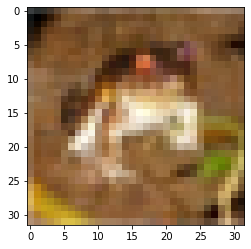

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


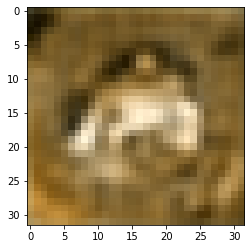

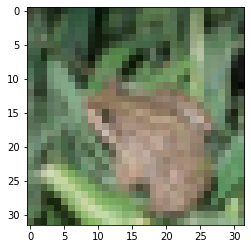

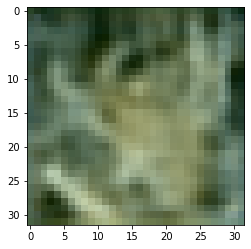

In [12]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
unNormer = UnNormalize(mean, std)
net.eval()
for i in trainset:
  plt.imshow(unNormer(i[0]).detach())
  plt.show()
  recon = net(i[0].cuda().unsqueeze(0))[0].cpu()
  plt.imshow(unNormer(recon[0]).detach())
  # plt.imshow(recon[0].permute(1,2,0).detach())
  plt.show()
  break
for i in testset:
  plt.imshow(i[0].permute(1,2,0).detach())
  plt.show()
  recon = net(i[0].cuda().unsqueeze(0))[0].cpu()
  plt.imshow(recon[0].permute(1,2,0).detach())
  plt.show()
  break

# Sampling

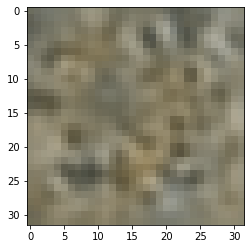

In [13]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
unNormer = UnNormalize(mean, std)
net.eval()
image = net.sample(1)[0].permute(1,2,0)
plt.imshow(unNormer(image).detach())
# plt.imshow(image.detach())